In [2]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp

In [49]:
#Parameters
#global kx,mu, m, t, alR, B, kF, a, al, delta, phi, delL, delR, nu0, tL, tR, NJ, eye2, s1, s2, s3, tP, tM, t3

kx=0.

mu=1.8
m=.5
t=3
alR=0.
def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
B=t/3     #looped
kF=np.sqrt(2*m*mu)

a=1/np.sqrt(2*m*t)
al=alR/a

delta=.5
phi=np.pi
def delL(phi):
    return delta*cmath.exp(1j*phi/2)
def delR(phi):
    return delta*cmath.exp(-1j*phi/2)
nu0=m/(2*np.pi)
def xiE(En):
    return kF/(m*cmath.sqrt(delta**2-En**2))

tL=2
tR=tL
#def TT(B):
#    return -mut(0)+np.sqrt(t**2+B**2)

GammaL=np.pi*nu0*tL**2 #=m*tL**2/2
GammaR=np.pi*nu0*tR**2 #=m*tR**2/2

NJ=14
W=NJ*a

ET=np.pi/2*kF/m/(NJ*a)

kpl=np.sqrt(2*m*B)*a*NJ
print(ET)

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

0.5214572583394643


In [4]:
#Junction
def HJ0(kx,B):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
Hy=-t*t3+1j*al/2*np.kron(s3,s1)


def HJ(kx,B):
    start=cmm(HJ0(kx,B))
    HJs=start
    for n in range(2,NJ+1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy)])
        CT=sp.hstack([OT.transpose(),cmm(Hy.conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx,B):
    return En*np.eye(4*NJ)-HJ(kx,B).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF*a)*(cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF+kx)))+cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF-kx))))-1j

def gSC1m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,phi,B):
    return scipy.linalg.block_diag(gSC1m1(En,kx,phi),gJm1(En,kx,B),gSC2m1(En,kx,phi))+mHt.toarray()

In [5]:
En=0
zerogap=0.00001

def fdet(B):
    return np.linalg.det(Gtotm1(En,kx,phi,B))/(mu**(8*NJ))

Bmin=0
Bmax=10
Barray=[]
x0roots=np.linspace(Bmin,Bmax+0.1,np.int((Bmax-Bmin)/.1))
for i in range(len(x0roots)):
    print(i)
    x0=x0roots[i]
    solekx=opt.fsolve(fdet,np.asarray(x0))
    if abs(fdet(solekx))>zerogap or solekx<=0:# or solekx>2*np.pi+0.1 :
        solekx=[]
    solekx=np.ndarray.tolist(np.around(solekx,4))
    print(solekx)
    Barray.extend(solekx)
Barray=sorted(list(set(Barray)))

0


/usr/local/lib64/python2.7/site-packages/scipy/optimize/minpack.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  ml, mu, epsfcn, factor, diag)
/usr/local/lib64/python2.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[]
1
[0.2914]
2
[0.2914]
3
[0.2914]
4
[0.2914]
5
[0.2914]
6
[0.6756]
7
[0.6756]
8
[0.6756]
9
[0.2914]
10
[1.1482]
11
[1.1482]
12
[1.1482]
13
[1.1482]
14
[1.6861]
15
[1.6448]
16
[1.6448]
17
[1.6861]
18
[1.6861]
19
[1.6861]
20
[1.6861]
21
[1.6861]
22
[1.6861]
23
[1.6861]
24
[1.6861]
25
[1.6861]
26
[2.8706]
27
[2.8706]
28
[2.8706]
29
[2.8706]
30
[2.8706]
31
[2.8706]
32
[2.8706]
33
[2.8706]
34
[2.8706]
35
[2.8706]
36
[2.8706]
37
[1.6861]
38
[2.8706]
39
[4.1373]
40
[4.1373]
41
[4.1373]
42
[4.1373]
43
[4.1373]
44
[4.1373]
45
[4.1373]
46
[4.1373]
47
[4.1373]
48
[4.1373]
49
[1.6861]
50
[4.1373]
51
[5.4027]
52
[5.4027]
53
[5.4027]
54
[5.4027]
55
[5.4027]
56
[5.4027]
57
[5.4027]
58
[5.4027]
59
[5.4027]
60
[5.4027]
61
[5.4027]
62
[6.6044]
63
[6.6044]
64
[6.6044]
65
[6.6044]
66
[6.6044]
67
[6.6044]
68
[6.6044]
69
[6.6044]
70
[6.6044]
71
[6.6044]
72
[6.6044]
73
[7.6868]
74
[7.6868]
75
[7.6868]
76
[7.6868]
77
[7.6868]
78
[7.6868]
79
[7.6868]
80
[7.6868]
81
[]
82
[8.6028]
83
[8.6028]
84
[8.6028]
85
[

ALL transitions shown


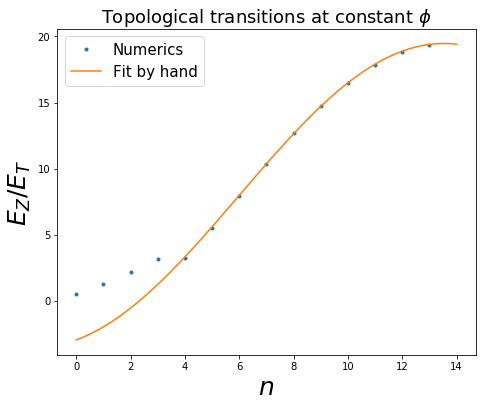

In [58]:
pp.figure(figsize=(7.5,6))
BarrayN=[x/ET for x in Barray]
pp.plot(range(len(Barray)),BarrayN,'.',label='Numerics')
if len(Barray)==NJ:
    print("ALL transitions shown")
else:
    print("MISSING transitions")

xbarray=np.linspace(0,14,201)
g=1.07712
gp=0.988095
gpp=1.5492
#ybarray=g*NJ/np.pi*np.arccos(-(xbarray+(mu-2*t)*gp)/(2*t))-NJ+len(Barray)-1.5492#(np.pi+phi)/2/np.pi*gpp
ybarray=(gp*(2*t-mu)-2*t*np.cos((xbarray+gpp)*np.pi/g/NJ))/ET
#zbarray=(np.pi*xbarray/W-kF+gpp)*kF/m/2/g
pp.plot(xbarray,ybarray,label='Fit by hand')
#pp.plot(xbarray,zbarray)
pp.ylabel('$E_Z/E_T$',fontsize=25)
pp.xlabel('$n$',fontsize=25)
pp.title('Topological transitions at constant $\phi$',fontsize=18)
pp.legend(fontsize=15)
#pp.axis([0,11,0,10])

In [59]:
mu/ET

3.4518648867443993

Compute the gap at the center of the topological phase

In [275]:
NM=int(len(Barray)/2)

L=50 #kx decimation
kxarray=np.linspace(-(kF+alR)-0.1,0.1,L+1)
EJdisp=np.zeros((4*(NJ+2),L+1))

for tp in range(NM):
    print("Topological phase nr.",tp)
    B=5#(Barray[2*tp+1]+Barray[2*tp])/2
    print(B)
    for j in range(L+1):
        print(j)
        ekx=[]
        kx=kxarray[j]
        def fdet(En):
            return np.linalg.det(Gtotm1(En,kx,phi,B))/(mu**(8*NJ))
        x0roots=np.ndarray.tolist(np.linspace(-delta,delta,np.int(2*delta/0.01)))
        for i in range(len(x0roots)):
            x0=x0roots[i]
            solekx=opt.fsolve(fdet,np.asarray(x0))
            if abs(fdet(solekx))>10**(-6) or abs(solekx)>=delta:
                solekx=[]
            solekx=np.ndarray.tolist(np.around(solekx,5))
            ekx.extend(solekx)
        ekx=list(set(ekx))
        print(ekx)
        if len(ekx)<4*(NJ+2):
            zerocompletion=[delta]*(4*(NJ+2)-len(ekx))
            ekx.extend(zerocompletion)
        elif len(ekx)>4*(NJ+2):
            print("Too many roots.")
            break
        for p in range(4*(NJ+2)):
            EJdisp[p,j]=np.asarray(ekx[p])

    #extracting the gap
    truegap=min(min(np.ndarray.tolist(np.abs(EJdisp))))
    print("gap=",truegap)
    

('Topological phase nr.', 0)
5
0


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in divide


[0.48865, -0.48865]
1
[0.42937, -0.42937]
2
[0.36946, -0.36946]
3
[-0.31302, 0.31302]
4
[-0.26108, 0.26108]
5


KeyboardInterrupt: 

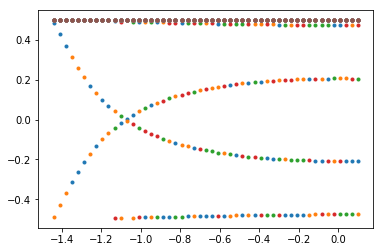

In [274]:
for p in range(len(EJdisp)):
    pp.plot(kxarray,EJdisp[p],'.')

B=4 gap=0.00082

B=4.5 gap=0.00564

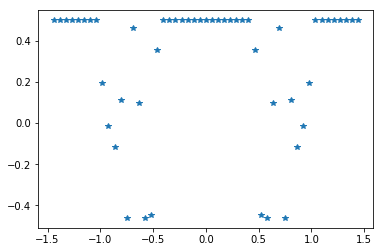

In [238]:
pp.plot(kxarray,EJdisp[2],'*')

In [265]:
(np.asarray(Barray[0:-2])+np.asarray(Barray[1:-1]))/2

array([], dtype=float64)

In [266]:
B

6.2606